## Modules à importer

In [1]:
import numpy as np
import ipywidgets as ipw
import matplotlib.pyplot as plt
from variaIa.variaIa import simplots
from importlib import reload
import glob

## Sélections du zmax, survey, bins pour redshift et stretch

In [2]:
reload(simplots)

test = simplots.SimplePlots()

z_path = glob.glob("../Data/zmax*")
zc = ipw.Dropdown(options=z_path,
                  description='z_max choice:',
                  value=z_path[-2])

choice_data = ipw.interactive(test.choice_data, zc=zc)
display(choice_data)

############################################################

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'PS1')
    
set_data = ipw.interactive(test.set_data, su=su)
display(set_data)

############################################################

nb_z = ipw.IntSlider(min = 3, max = 30, value = 12,
                     description='#bins for z:', continuous_update=False)
nb_x = ipw.IntSlider(min = 3, max = 30, value = 12,
                     description='#bins for x:', continuous_update=False)

display(nb_z)
display(nb_x)

interactive(children=(Dropdown(description='z_max choice:', index=2, options=('../Data/zmax_result', '../Data/…

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3)

IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3)

## Tracé des redshifts de l'échantillon choisi

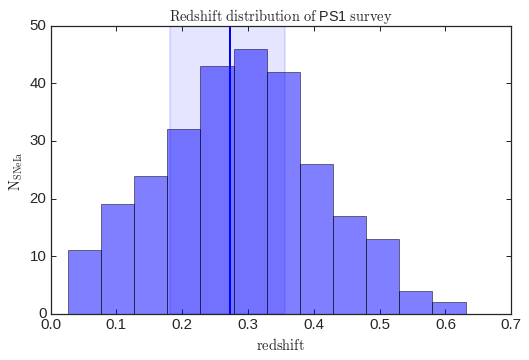

In [3]:
reload(simplots)

test.redshift_one(nb_z.value, True, True)

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/hist_'
#            + str(su.value) + '_095_cuts.pdf', bbox_inches='tight')

## Tracé du stretch de l'échantillon choisi, coupé à zmax

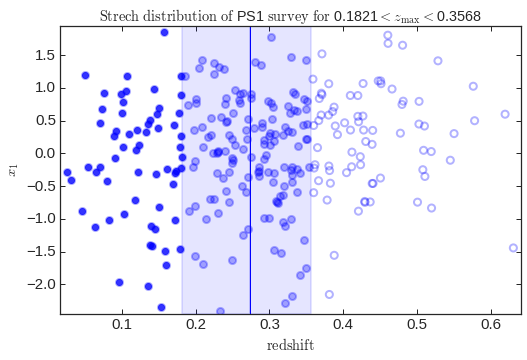

In [4]:
test.stretch_one()

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/stretch_'
#            + str(su.value) + '_spec_cuts.pdf', bbox_inches='tight')

## Tracé total : $x_1$, $z$, $z_{\mathrm{cuts}}$, histogrammes

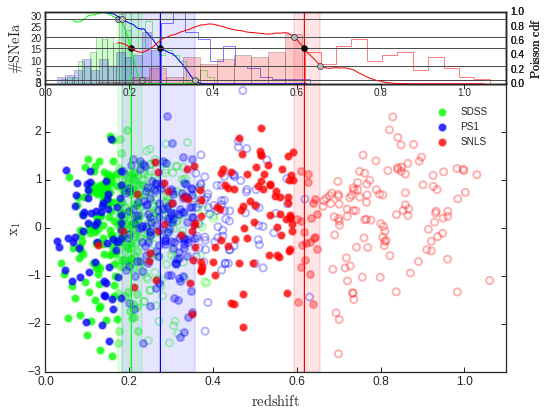

In [5]:
reload(simplots)

test.plot_all(nb_x.value, True, True, True, True)